In [21]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import clone
%matplotlib inline

#Data Preprocessing and Feature Engineering
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.stem.snowball import ItalianStemmer
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD

#Model Selection and Validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score


def labels_to_ints(labels):
    return np.array(list(map(lambda x : 1 if x == "pos" else 0, labels)))

def ints_to_labels(labels):
    return list(map(lambda x : "pos" if x == 1 else "neg", labels))

In [11]:
dev_df = pd.read_csv("datasets/development.csv")
X_dev = dev_df.loc[:, 'text']
y_dev = labels_to_ints(dev_df.loc[:, 'class'])

ev_df = pd.read_csv("datasets/evaluation.csv")
X_ev = ev_df.loc[:, 'text']

X_dev.shape[0] + X_ev.shape[0]

41077

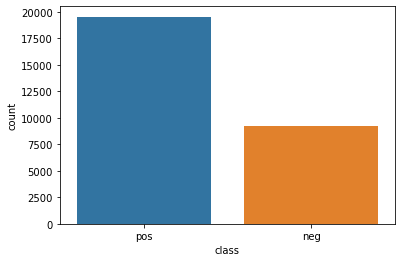

In [12]:
sns.countplot(x= 'class',data = dev_df)


In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'url', text) # remove URLs
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "email", text) # remove email
    text = re.sub(r'@([^\s]+)', r'\1', text) # remove eventually @<word>
    text = re.sub(r'#([^\s]+)', r'\1', text) # remove eventually hashtag 
    text = re.sub(r'[#@]', " ", text) # remove eventually isolated @#
    text = re.sub("'", "' ", text)  #insert a space in every word with the <'> in order to be catched by tokenizer and filtered
    text = re.sub(r"([.]*)([0-9]+)([.]*)", r"\0 \1", text) # i.e ciao123come20va -> ciao come va
    text = re.sub("([*.\-/+°])", " ", text) # remove special characters from words of kind "..<word>" "***" "-<word>" "..<word>"
    return text

class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = ItalianStemmer()
    
    def __call__(self, text):
        lemmas = []
        regex = re.compile("[0-9]+")
        stopwords = sw.words('italian') + ['quantum', "url", "email", 'sempre', 'stato', 'stati', 'stata', 'state', 'ogni', 'tutto', 'tutti', 'tutta', 'tutte']
        text = preprocess_text(text)
        for t in word_tokenize(text):
            t = t.strip()
            if t not in string.punctuation and 3 < len(t) < 16 and not regex.match(t) and t not in stopwords:
                lemma = self.stemmer.stem(t)
                lemmas.append(lemma)
        return lemmas
    

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, shuffle=True, test_size=0.20)
pipeNB = Pipeline([
    ('tfidf', TfidfVectorizer(input='content', min_df=10, tokenizer=LemmaTokenizer(), ngram_range=(1,2))),
    ('model', MultinomialNB())
])

pipeLR = Pipeline([
    ('tfidf', TfidfVectorizer(input='content', min_df=10, tokenizer=LemmaTokenizer(), ngram_range=(1,2))),
    ('model', LogisticRegression(C=10, max_iter=200, n_jobs=8))
])

pipeNB.fit(X_train, y_train)
pipeLR.fit(X_train, y_train)
y_pred_NB = pipeNB.predict(X_test)
y_pred_LR = pipeLR.predict(X_test)

In [23]:
print("Naive Bayes")
print(classification_report(y_test, y_pred_NB))
print(f1_score(y_test, y_pred_NB))
print("\nLogistic Regression")
print(classification_report(y_test, y_pred_LR))
print(f1_score(y_test, y_pred_LR))

Naive Bayes
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1844
           1       0.95      0.98      0.97      3907

    accuracy                           0.95      5751
   macro avg       0.96      0.93      0.94      5751
weighted avg       0.95      0.95      0.95      5751

0.9654999372726133

Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1844
           1       0.97      0.98      0.98      3907

    accuracy                           0.97      5751
   macro avg       0.96      0.96      0.96      5751
weighted avg       0.97      0.97      0.97      5751

0.9752066115702479


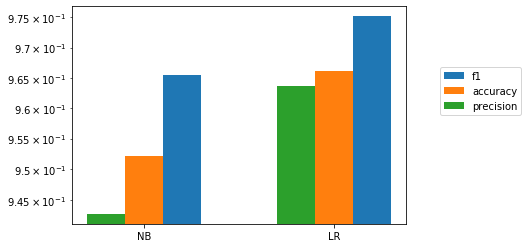

In [39]:
from sklearn.metrics import accuracy_score, average_precision_score 
f1_scores = [f1_score(y_test, y_pred_NB), f1_score(y_test, y_pred_LR)]
acc_scores = [accuracy_score(y_test, y_pred_NB), accuracy_score(y_test, y_pred_LR)]
prec_scores = [average_precision_score(y_test, y_pred_NB), average_precision_score(y_test, y_pred_LR)]
x = np.arange(2)
width = 0.2
labels = ['NB', 'LR']
_, ax = plt.subplots()
ax.bar(x+width, f1_scores, width=width, label='f1')
ax.bar(x, acc_scores, width=width, label='accuracy')
ax.bar(x-width, prec_scores, width=width, label='precision')
ax.set_xticks(x) # setup positions of x ticks
ax.set_xticklabels(labels) 
ax.set_yscale('log')
ax.legend(loc=(1.1, 0.5))
plt.show()

In [7]:
labels_predicted = []
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    labels_predicted.append(y_pred)
    

In [8]:
total_config = []
for conf_vec in ParameterGrid(params_vect):
    for conf_mod in ParameterGrid(params_model):
        total = conf_vec
        total.update(conf_mod)
        total_config.append(total)

{'classifier__C': 15, 'classifier__class_weight': None, 'count__min_df': 5, 'count__ngram_range': (1, 2), 'count__strip_accents': 'unicode', 'pca__n_components': 100}


In [9]:
f1_scores = [f1_score(y_test, y_pred) for y_pred in labels_predicted]
best_ind = np.argmax(f1_scores)
best_pipeline = pipelines[best_ind]
print(classification_report(y_test, labels_predicted[best_ind]))
print(f"Total f1 score: {np.max(f1_scores)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, labels_predicted[best_ind])}")
print(f"CountVectorizer best params: {list(total_config[best_ind].items())[:2]}")
print(f"Logistic Regression best params: {list(total_config[best_ind].items())[2:]}")

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2260
           1       0.96      0.95      0.96      4929

    accuracy                           0.94      7189
   macro avg       0.93      0.94      0.93      7189
weighted avg       0.94      0.94      0.94      7189

[[2088  172]
 [ 238 4691]]
0.9581290849673203


In [12]:
final_pipe = clone(pipelines[best_ind])
final_pipe.steps.insert(2, ('svd', TruncatedSVD(n_components=10000)))
final_pipe.fit(X_dev, y_dev)

In [14]:
cum_variance = np.cumsum(final_pipe['svd'].explained_variance_ratio_)
n_comps = np.argmax(cum_variance > .8)
_, ax = plt.subplots()
ax.plot(cum_variance*100, list(range(len(cum_variance))))
ax.set_xlabel('cumulative variance (%)')
ax.set_ylabel('components')
plt.show()
n_comps


In [ ]:
pipeline_ev = Pipeline([
    ('count', best_pipeline['count']),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=n_comps)),
    ('classifier', best_pipeline['classifier']),
])
pipeline_ev.fit(X_dev, y_dev)
y_pred_ev = pipeline_ev.predict(X_ev)

In [ ]:
with open("datasets/sample_submission8.csv", "w", encoding="utf8") as sub:
    sub.write("Id,Predicted\n")
    for i, label in enumerate(ints_to_labels(y_pred_ev)):
        sub.write(f"{i},{label}\n")
 



In [ ]:
coefs = pipeline_ev['tfidf'].idf_
feature_names = pipeline_ev['count'].get_feature_names()
best_features = [feature_names[i] for i in np.argsort(coefs)[::-1]]
best_features[:100]